This notebook creates the train and test data sets for the content-based DNN classifier. The data are pulled from the publicly avialable Kurier.at dataset in BigQuery using SQL queries. This notebook only runs in Google Cloud Platform.

The schema of the data is [here](https://support.google.com/analytics/answer/3437719?hl=en). Let's take a look what the data are like (only part of columns are shown). We are interested in the values in hit.customDimensions.value column.

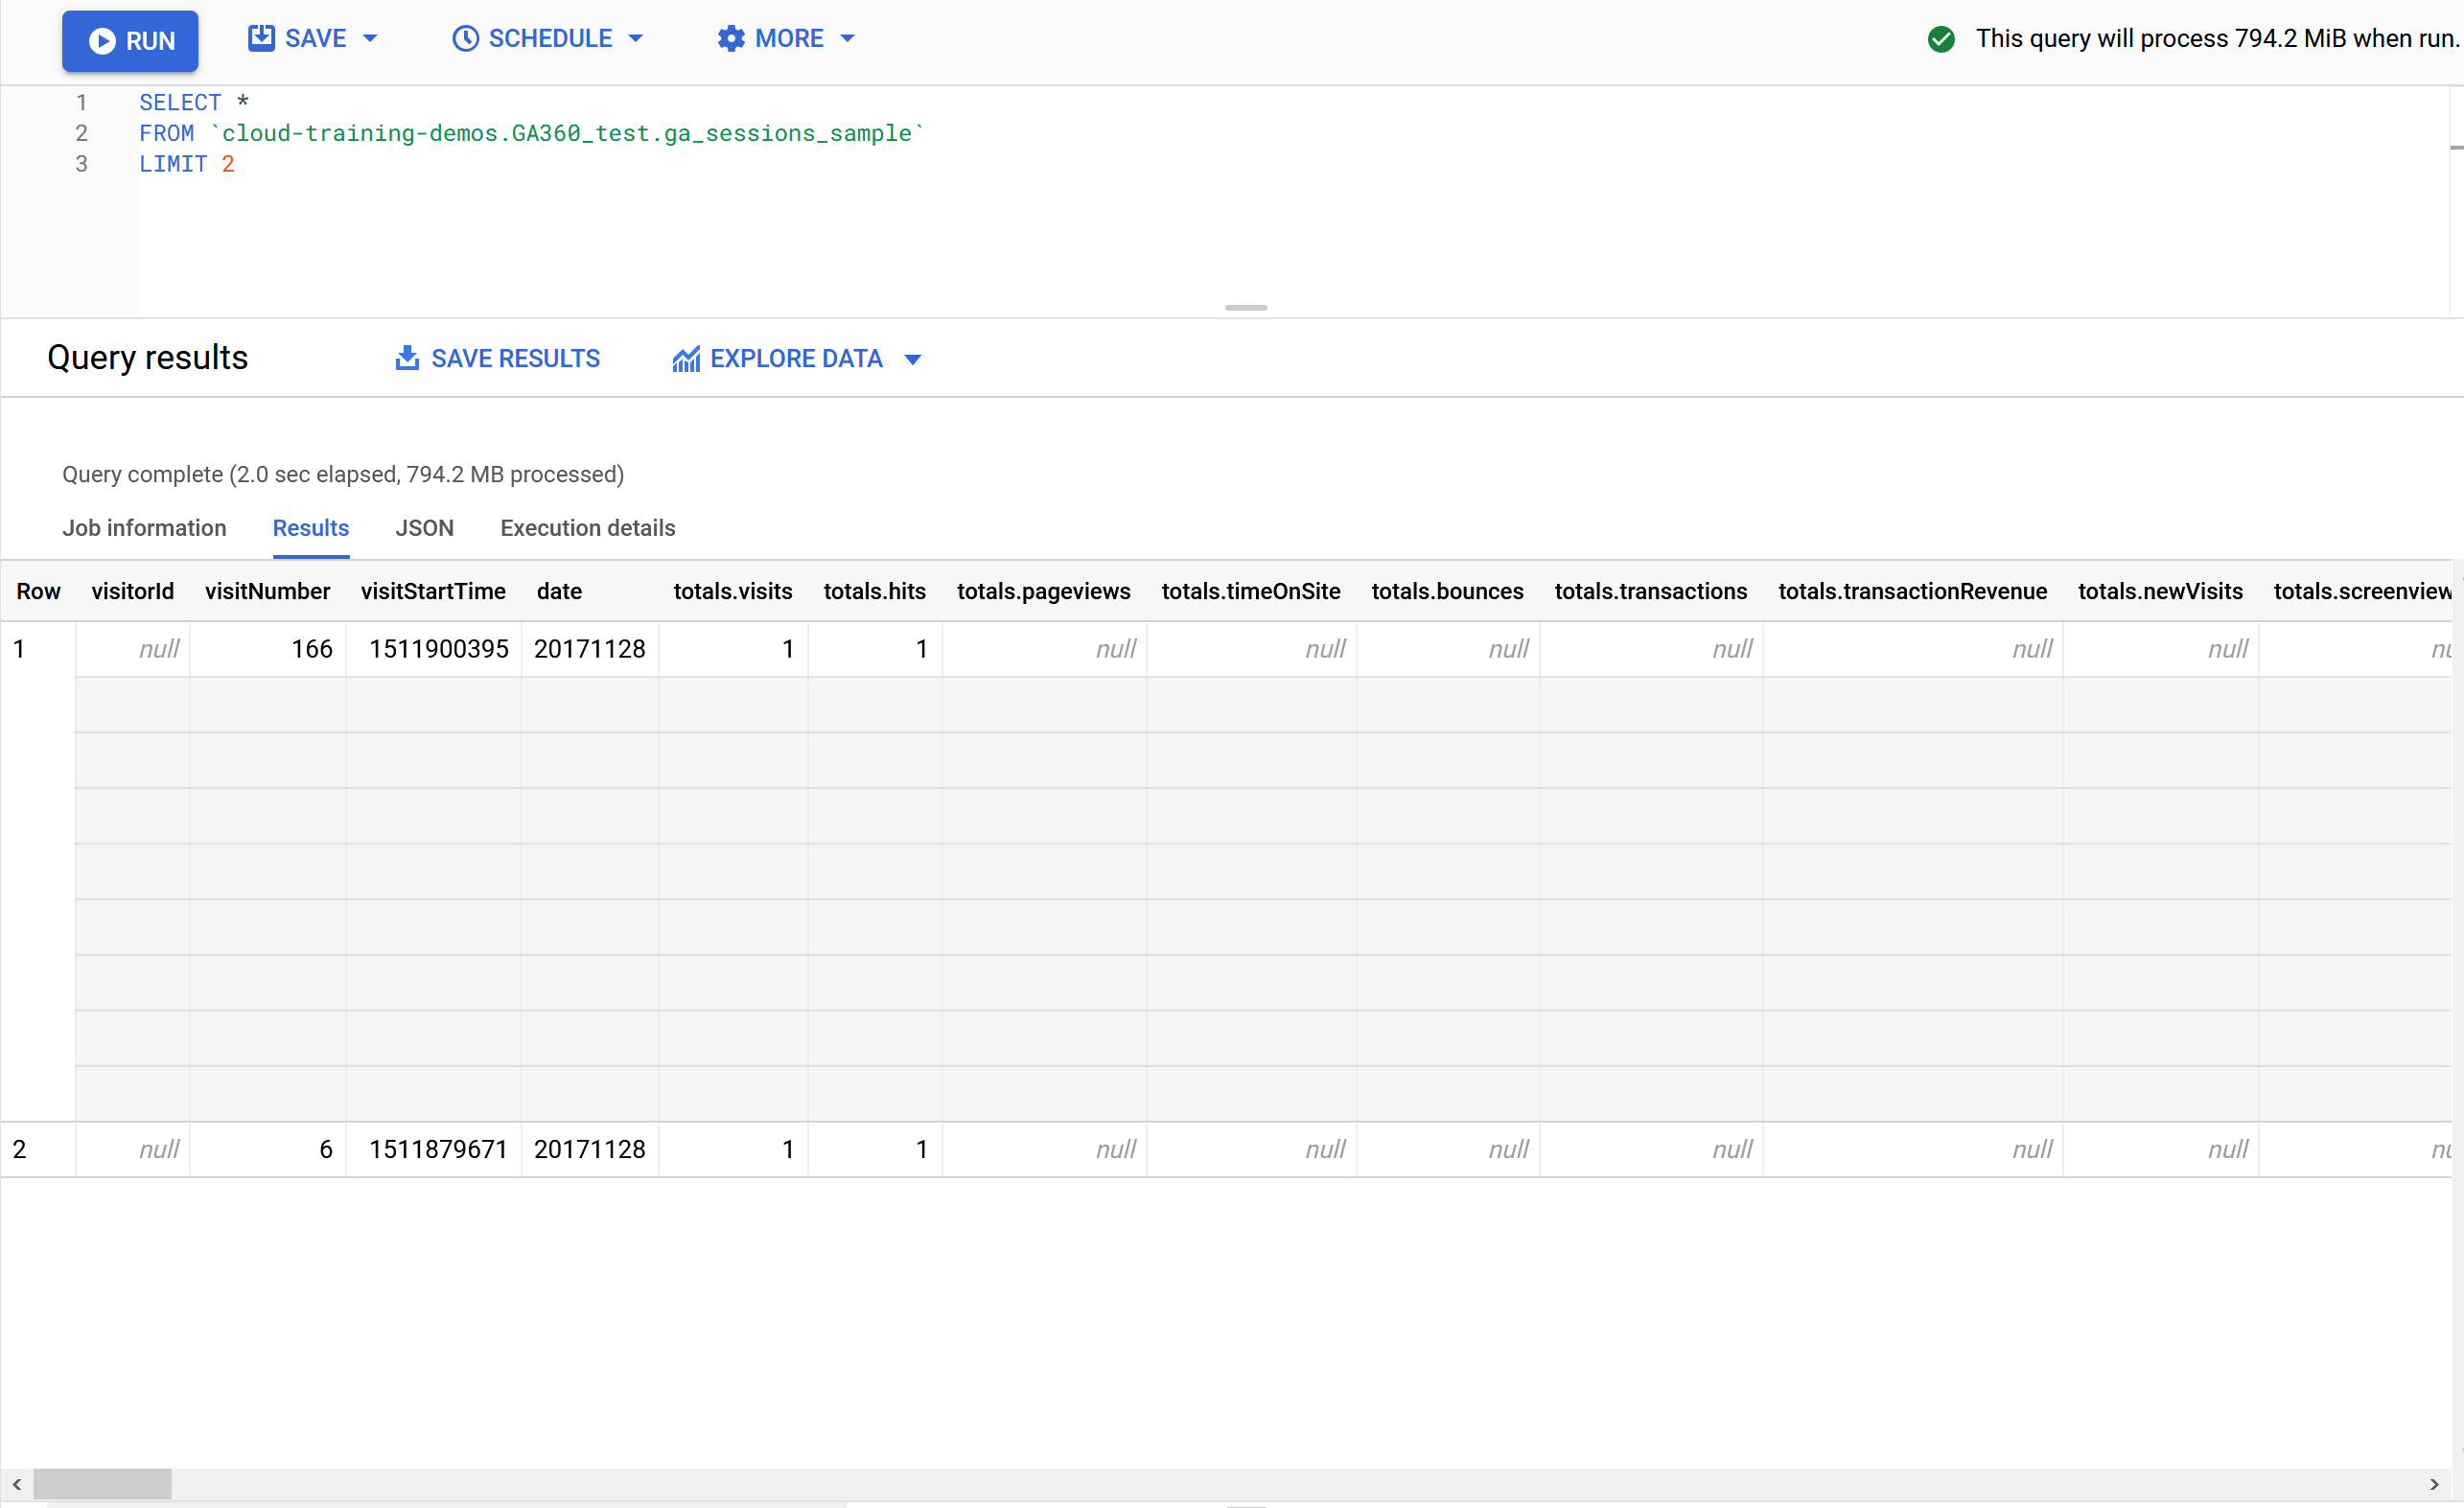

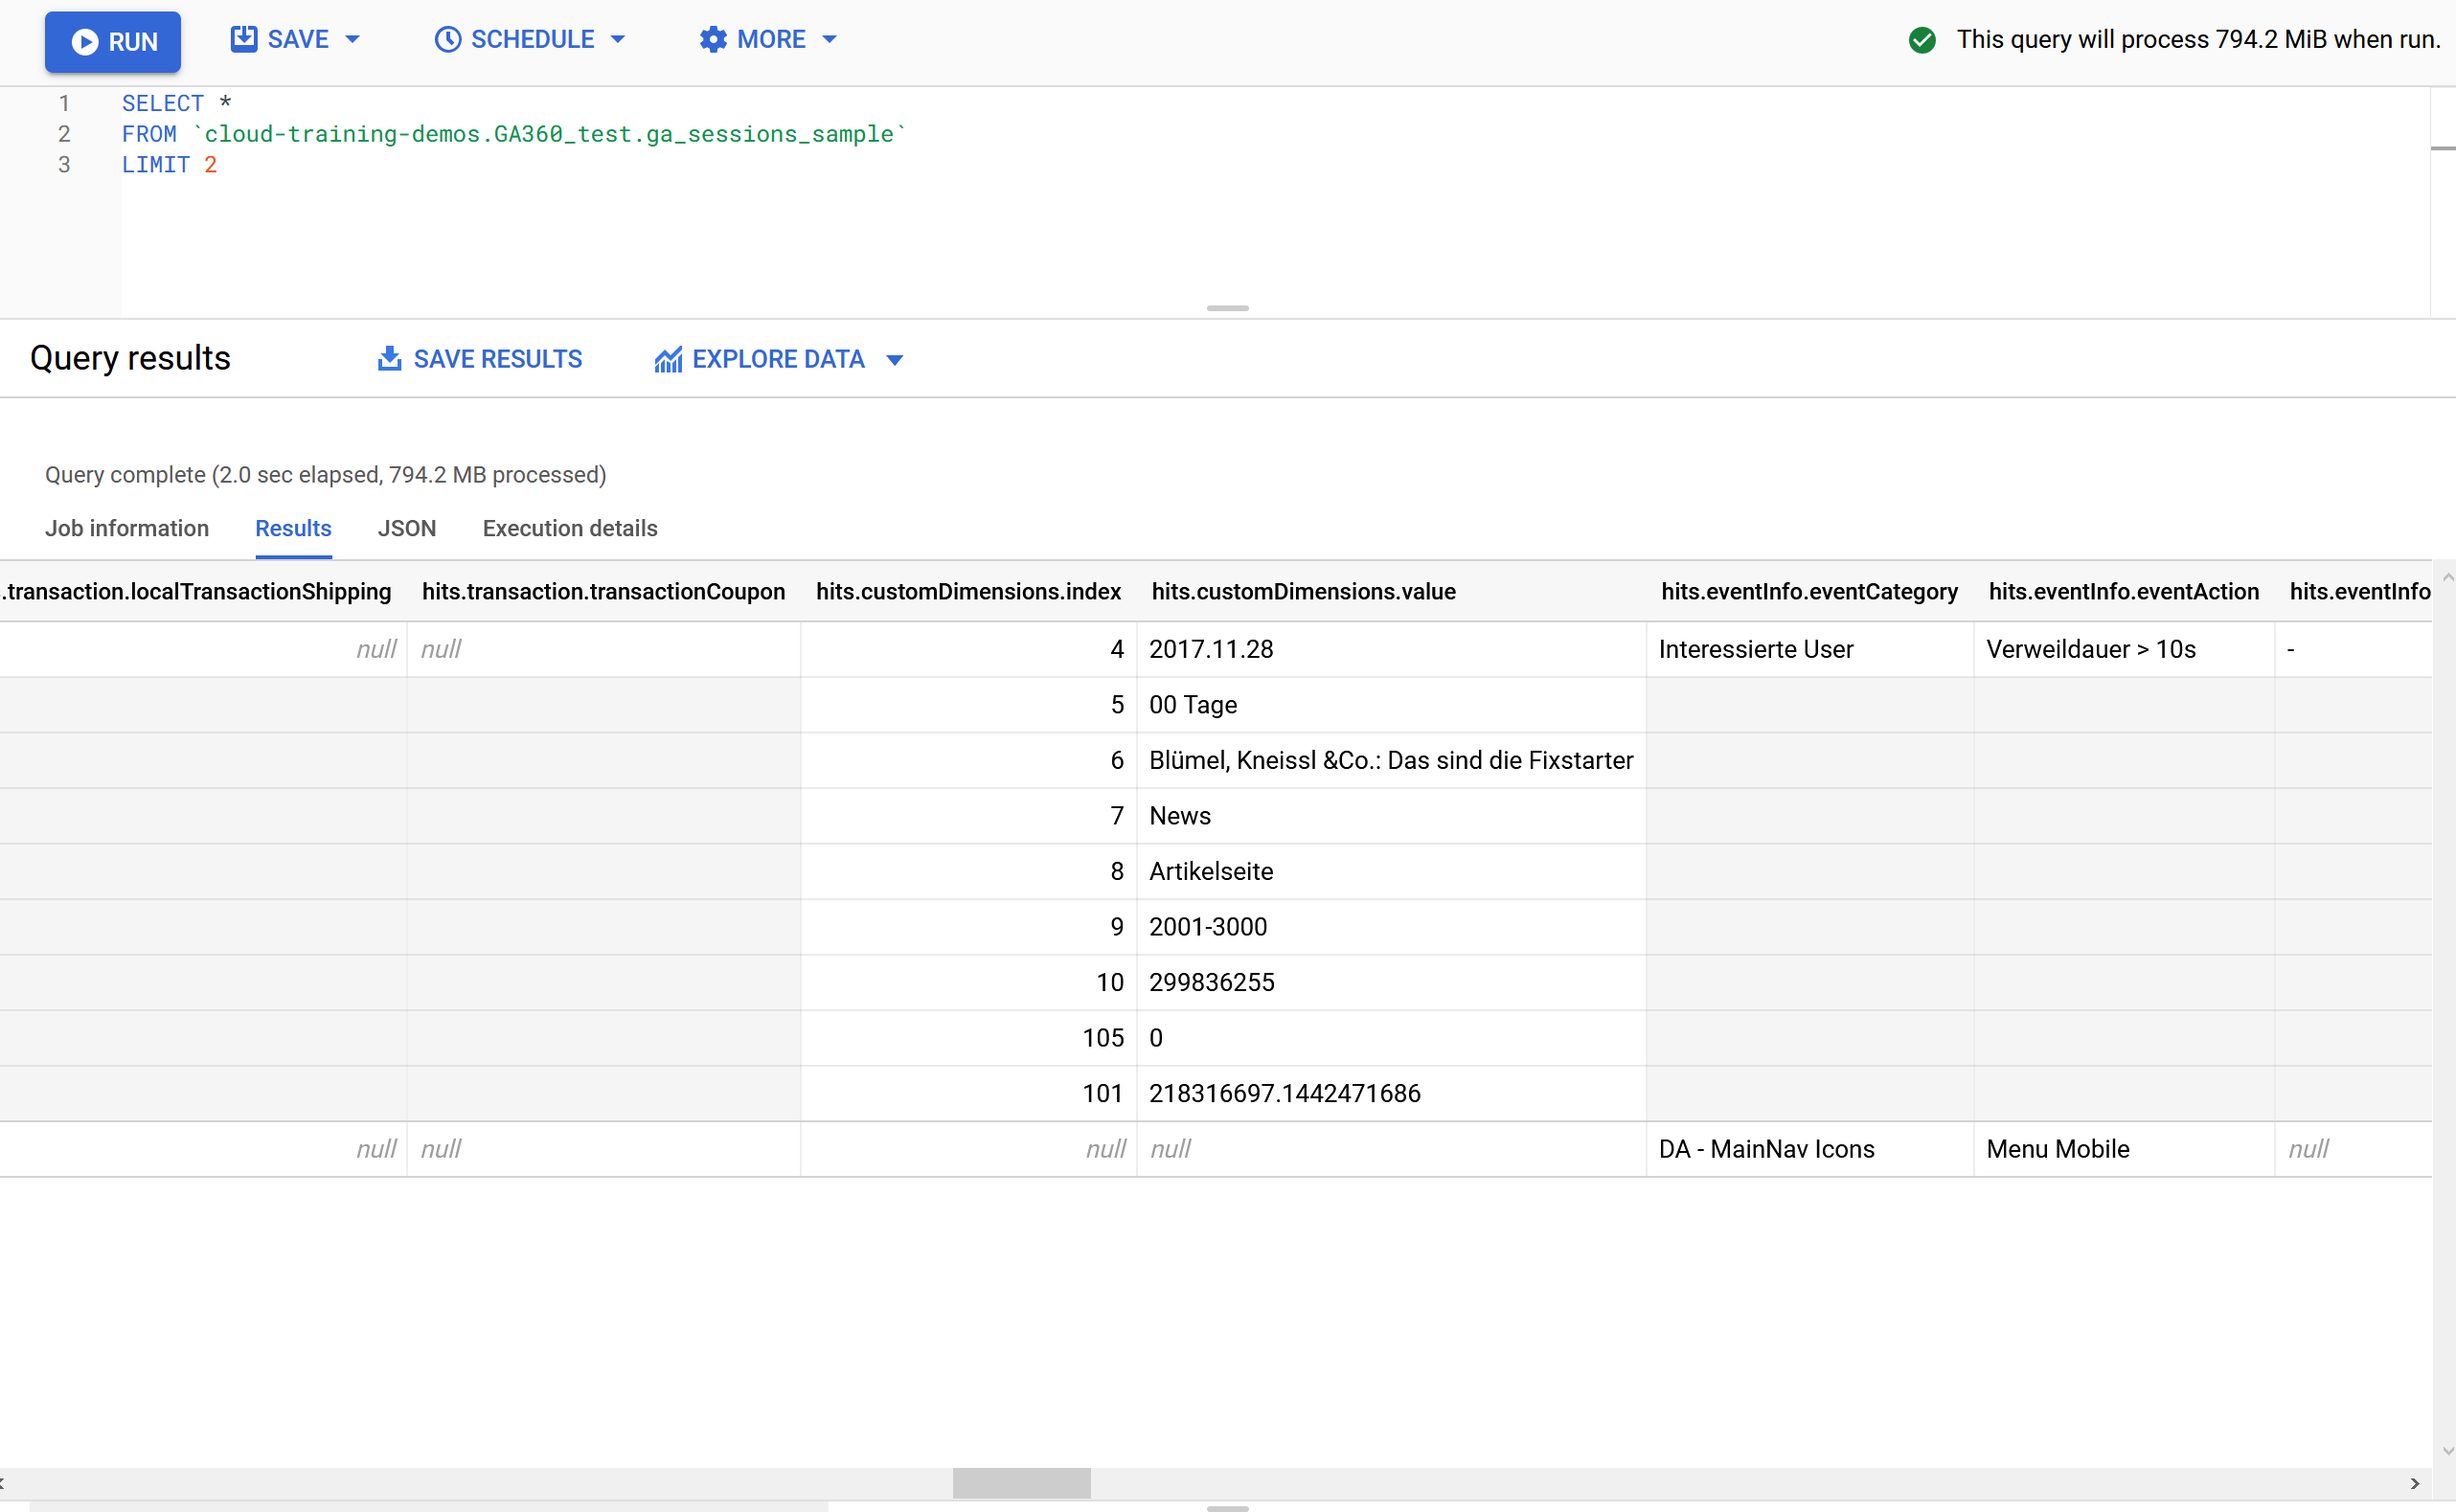

In [ ]:
from google.cloud import bigquery

In [ ]:
projectID = "virtual-metrics-284905"
client = bigquery.Client(location="US", project=projectID)

# 1. Create three lists - content IDs, article categories and author names.

In this section, we create three lists for later use in the neural network:


> List of content IDs.


> List of article categories.


> List of author names.






The hit.customDimensions.value column is a nested column. The levels in the columns are: hit -> customDimensions -> value, and the column of interest lies in the 'value' level. First I need to flatten the first two levels ('hit' and 'customDimensions'). The query and result are like this:

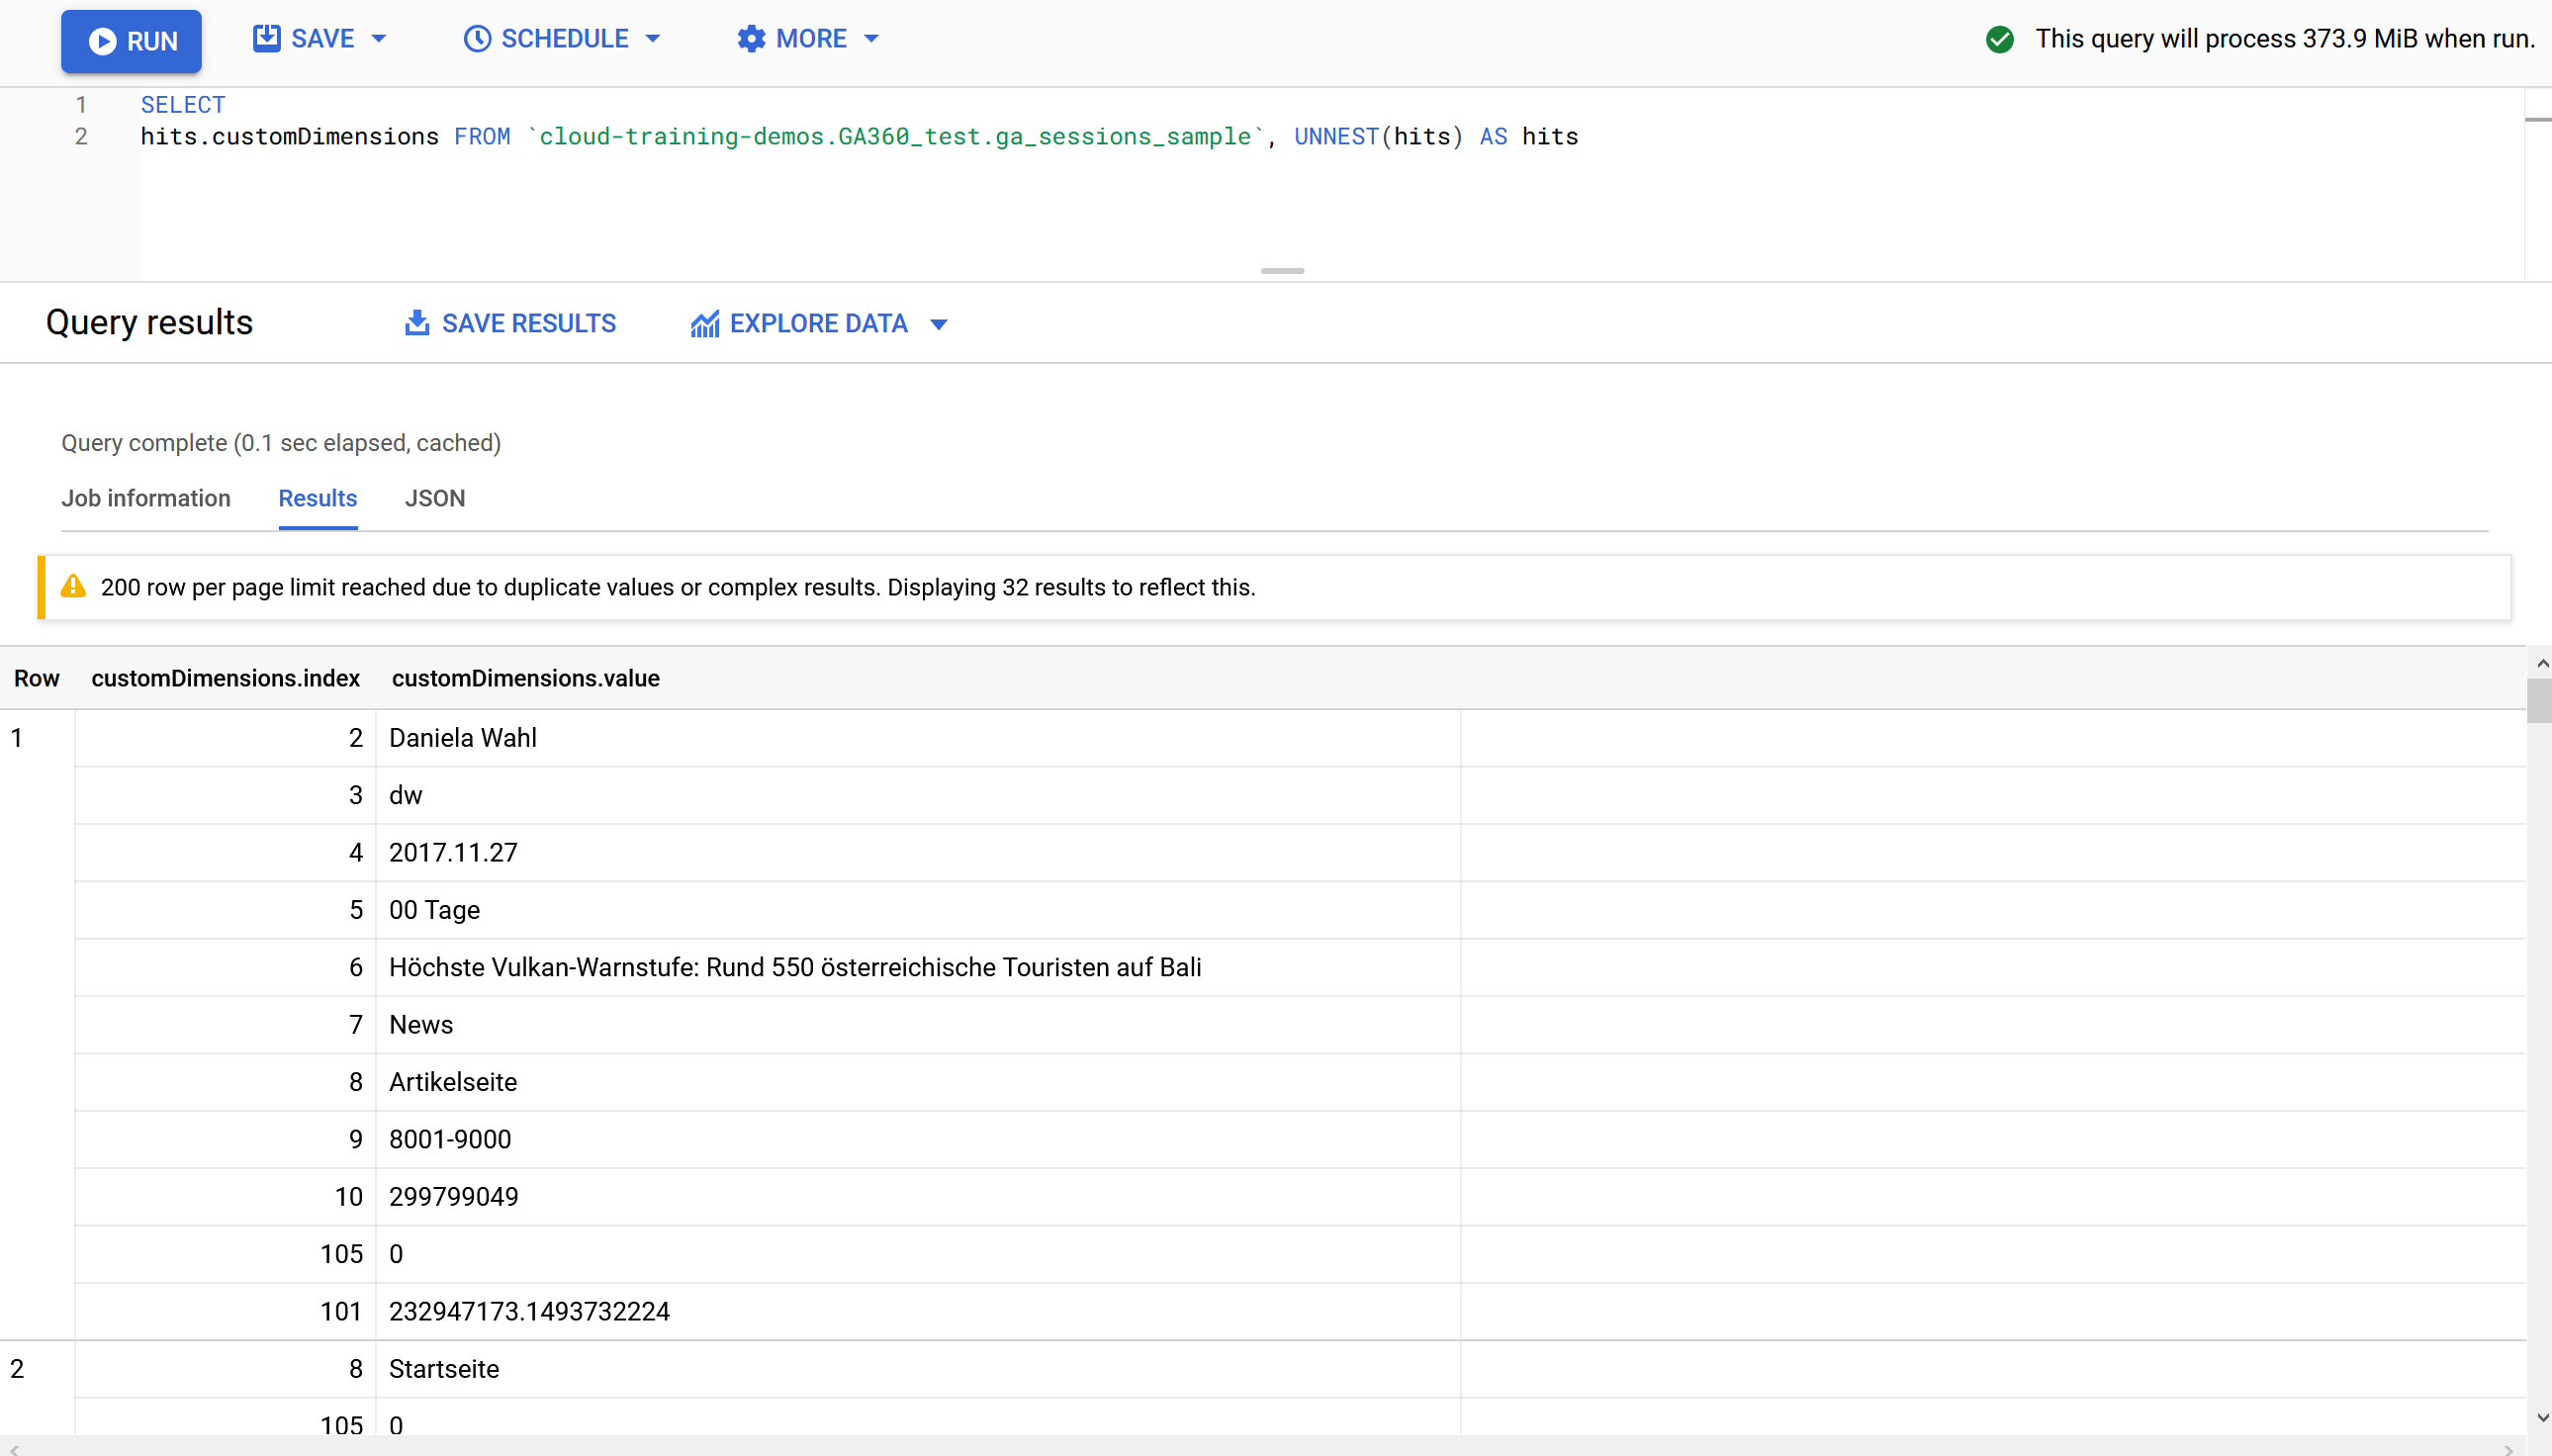

The content IDs are the values of index 10. Now we access to it. The query and result are like:

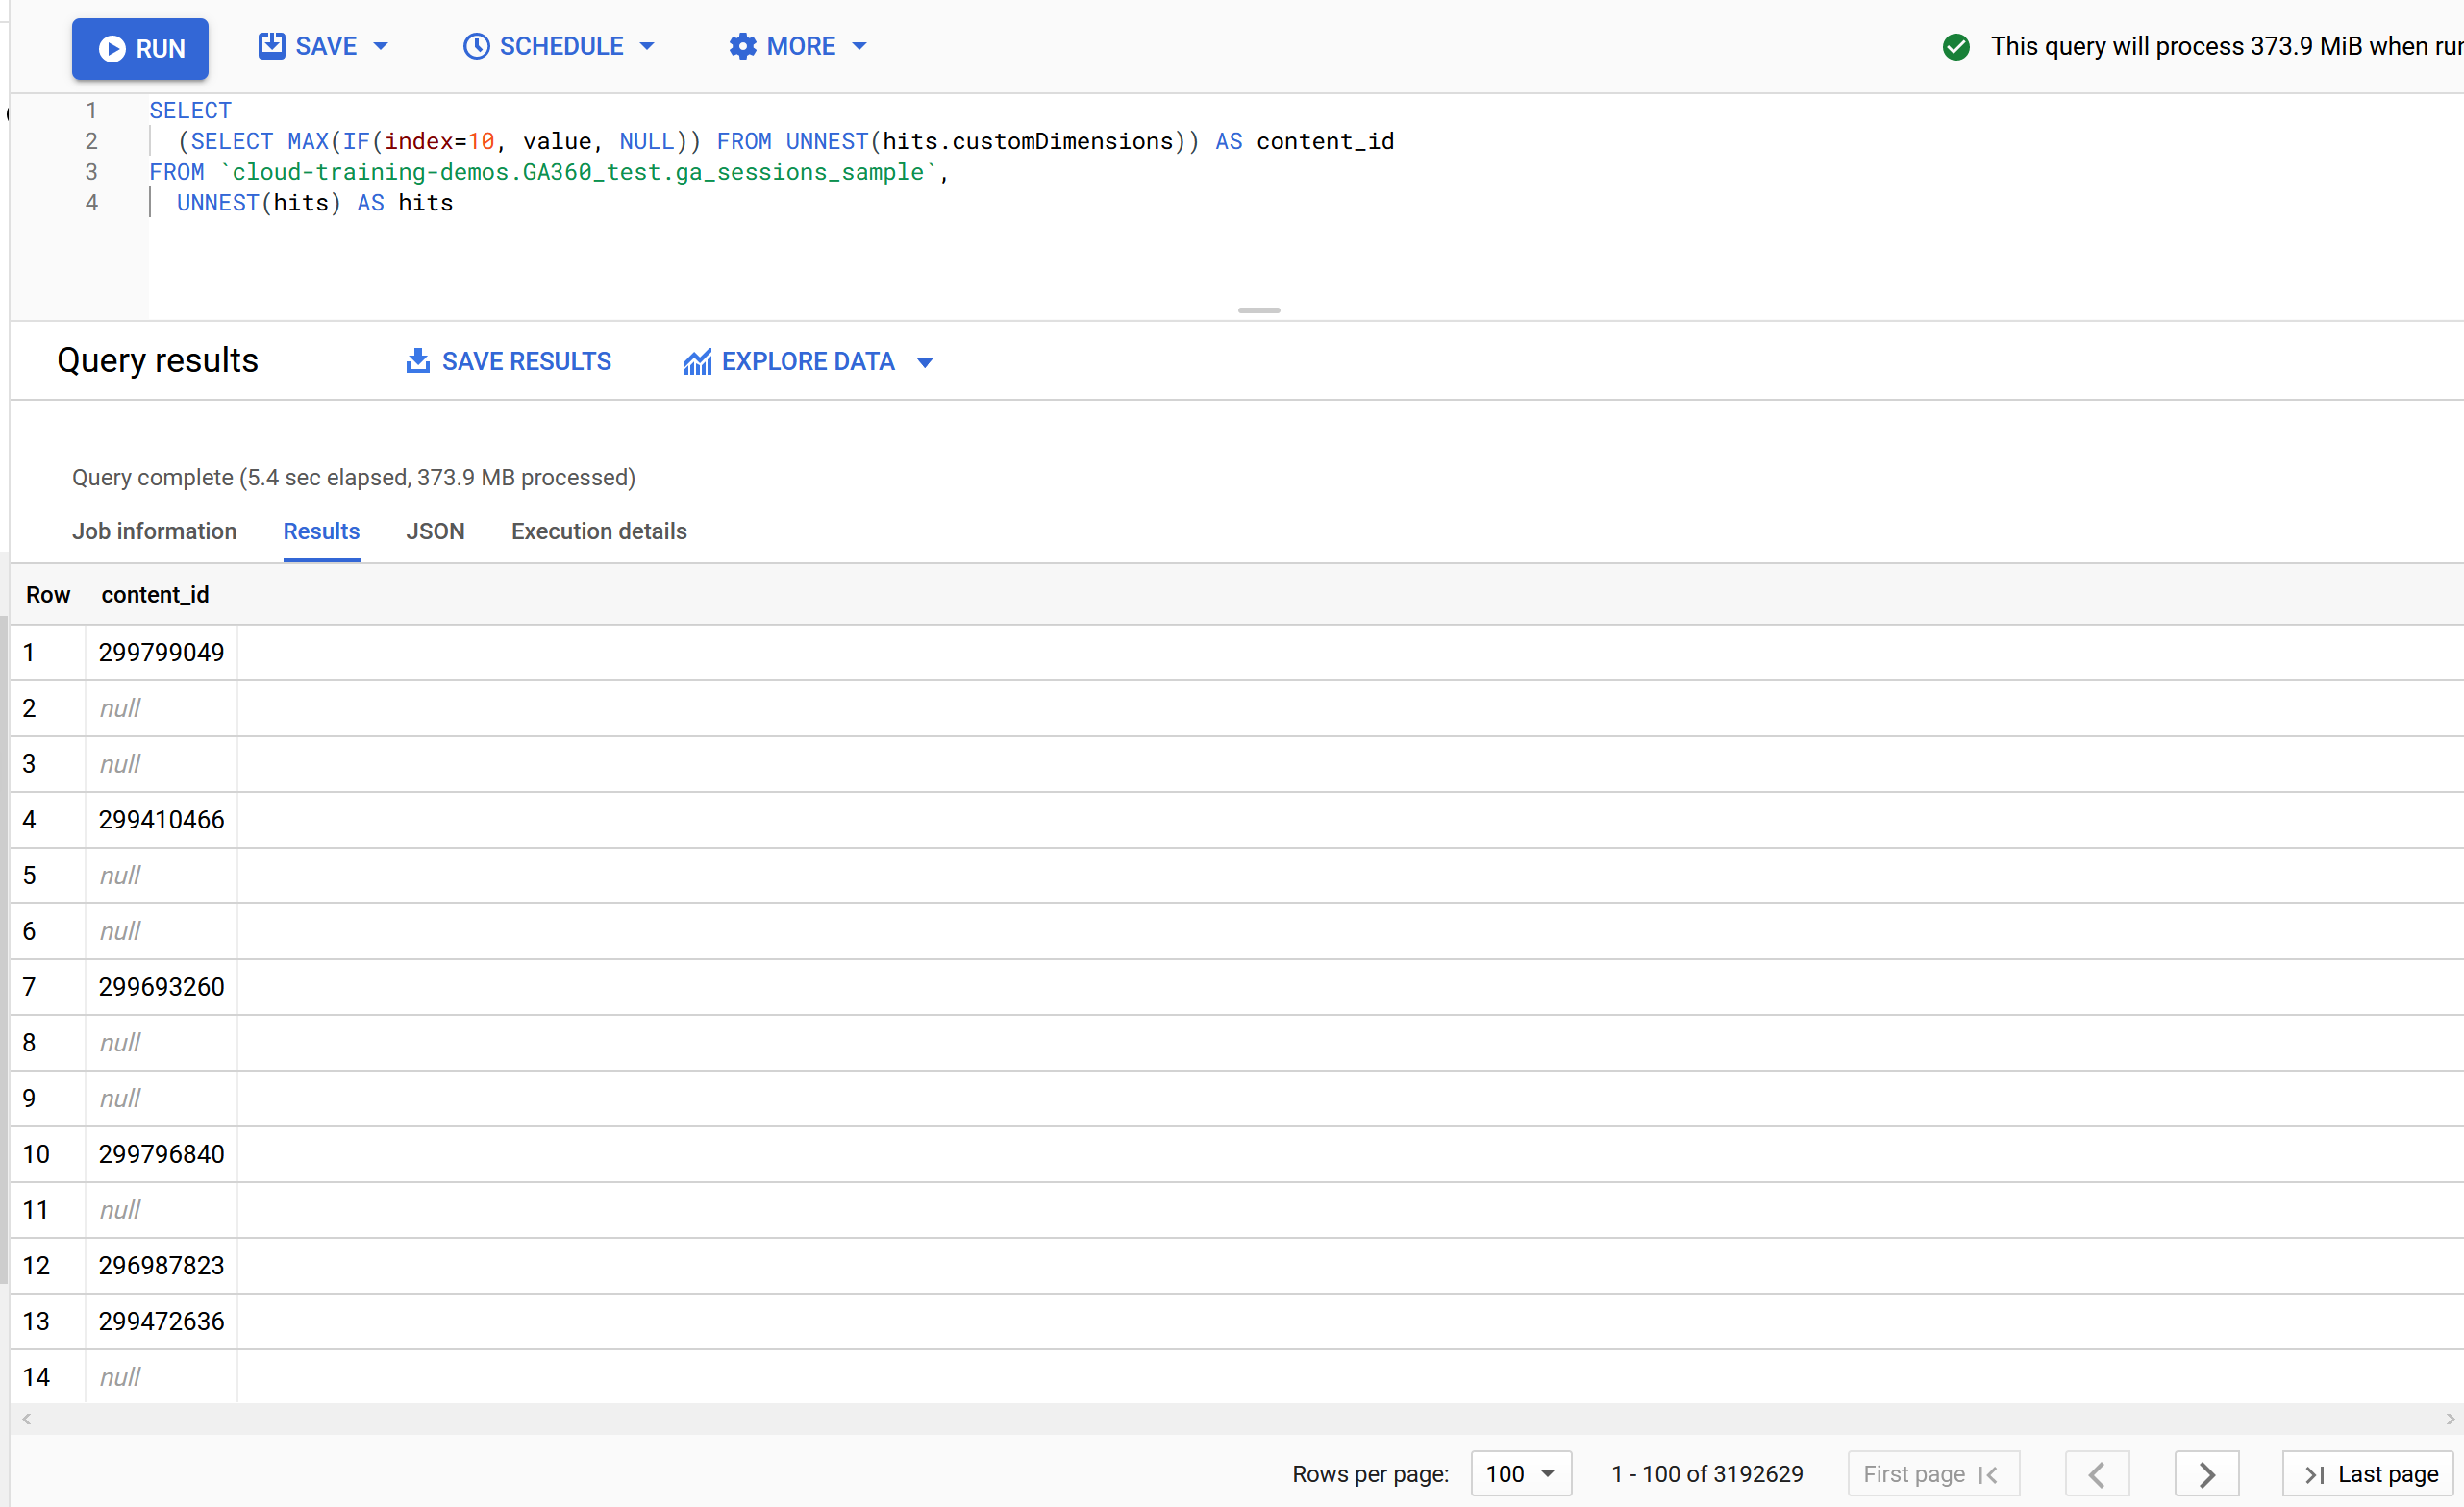

Next, we want to exclude the null values (using UNION), make content_id distinct (using GROUP BY clause), and only include hits on pages (using WHERE clause). The final query and result are like:

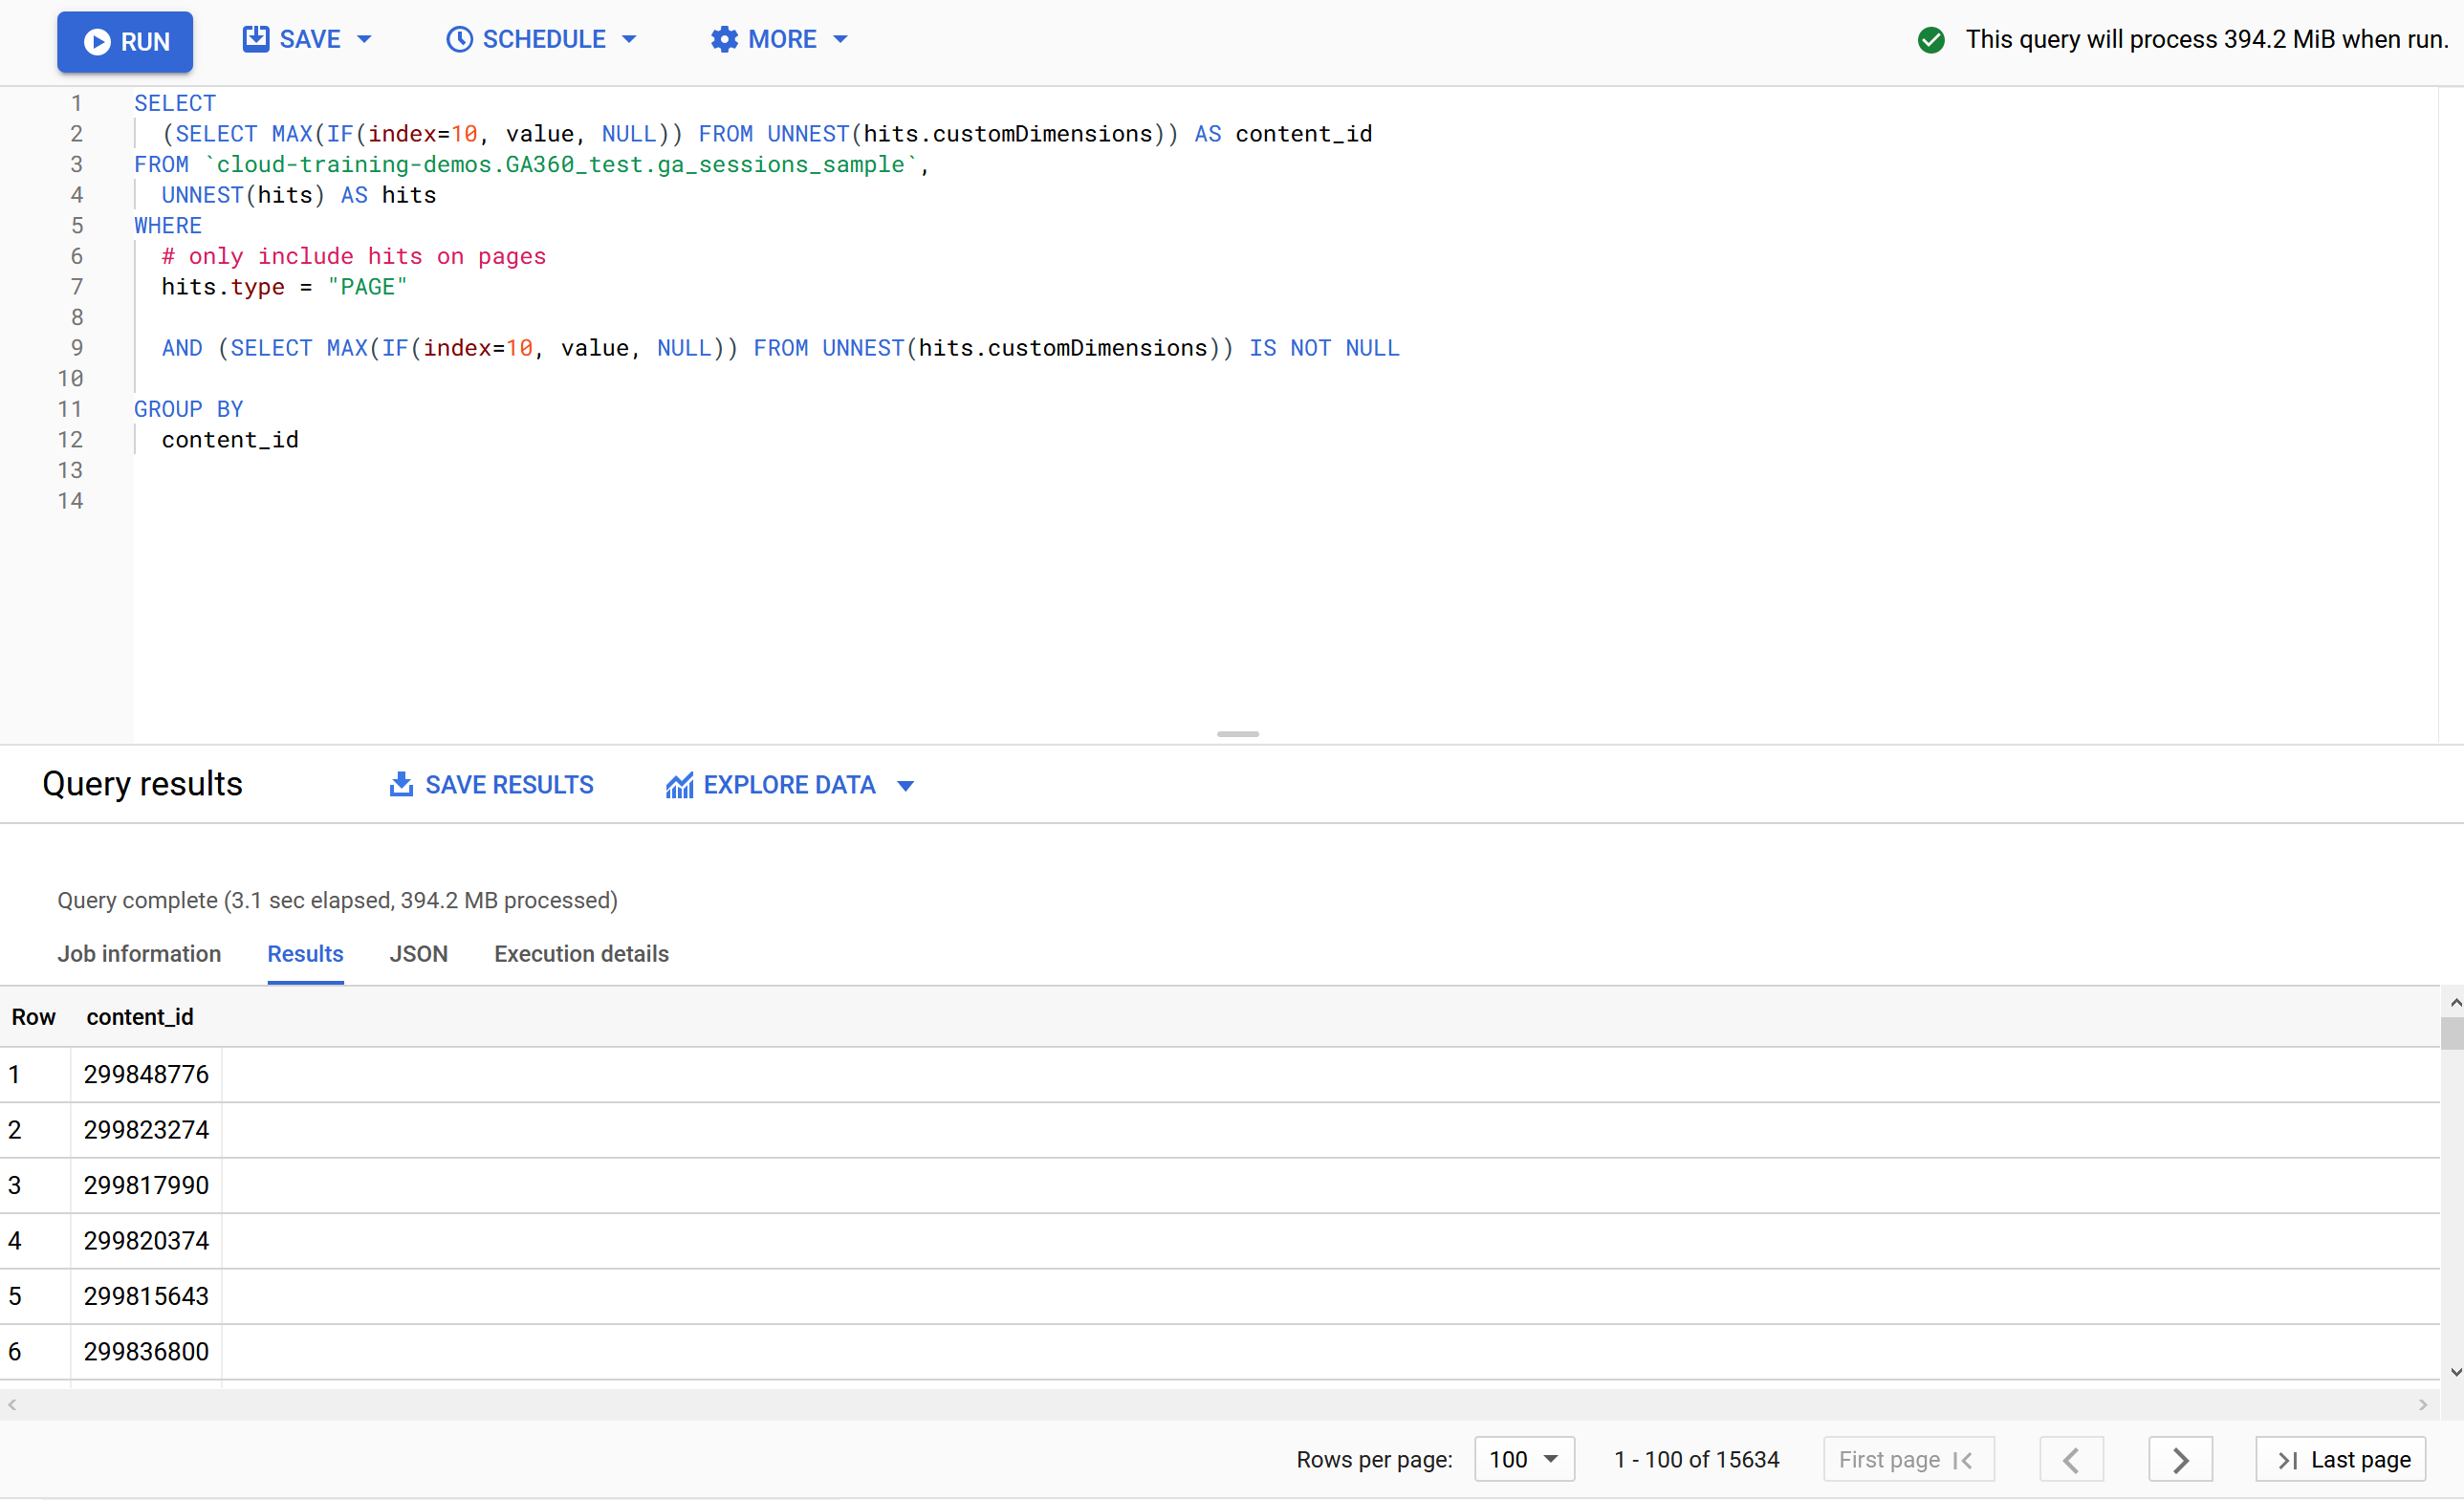

At last, we look at the execution details to see if it is possible to optimize the query. The figure below shows that most of the working time is spent on reading the data. The system first filters the "hits.type", then the "hits.customDimensions.index", last is the "hits.customDimensions.value". Looks all good.

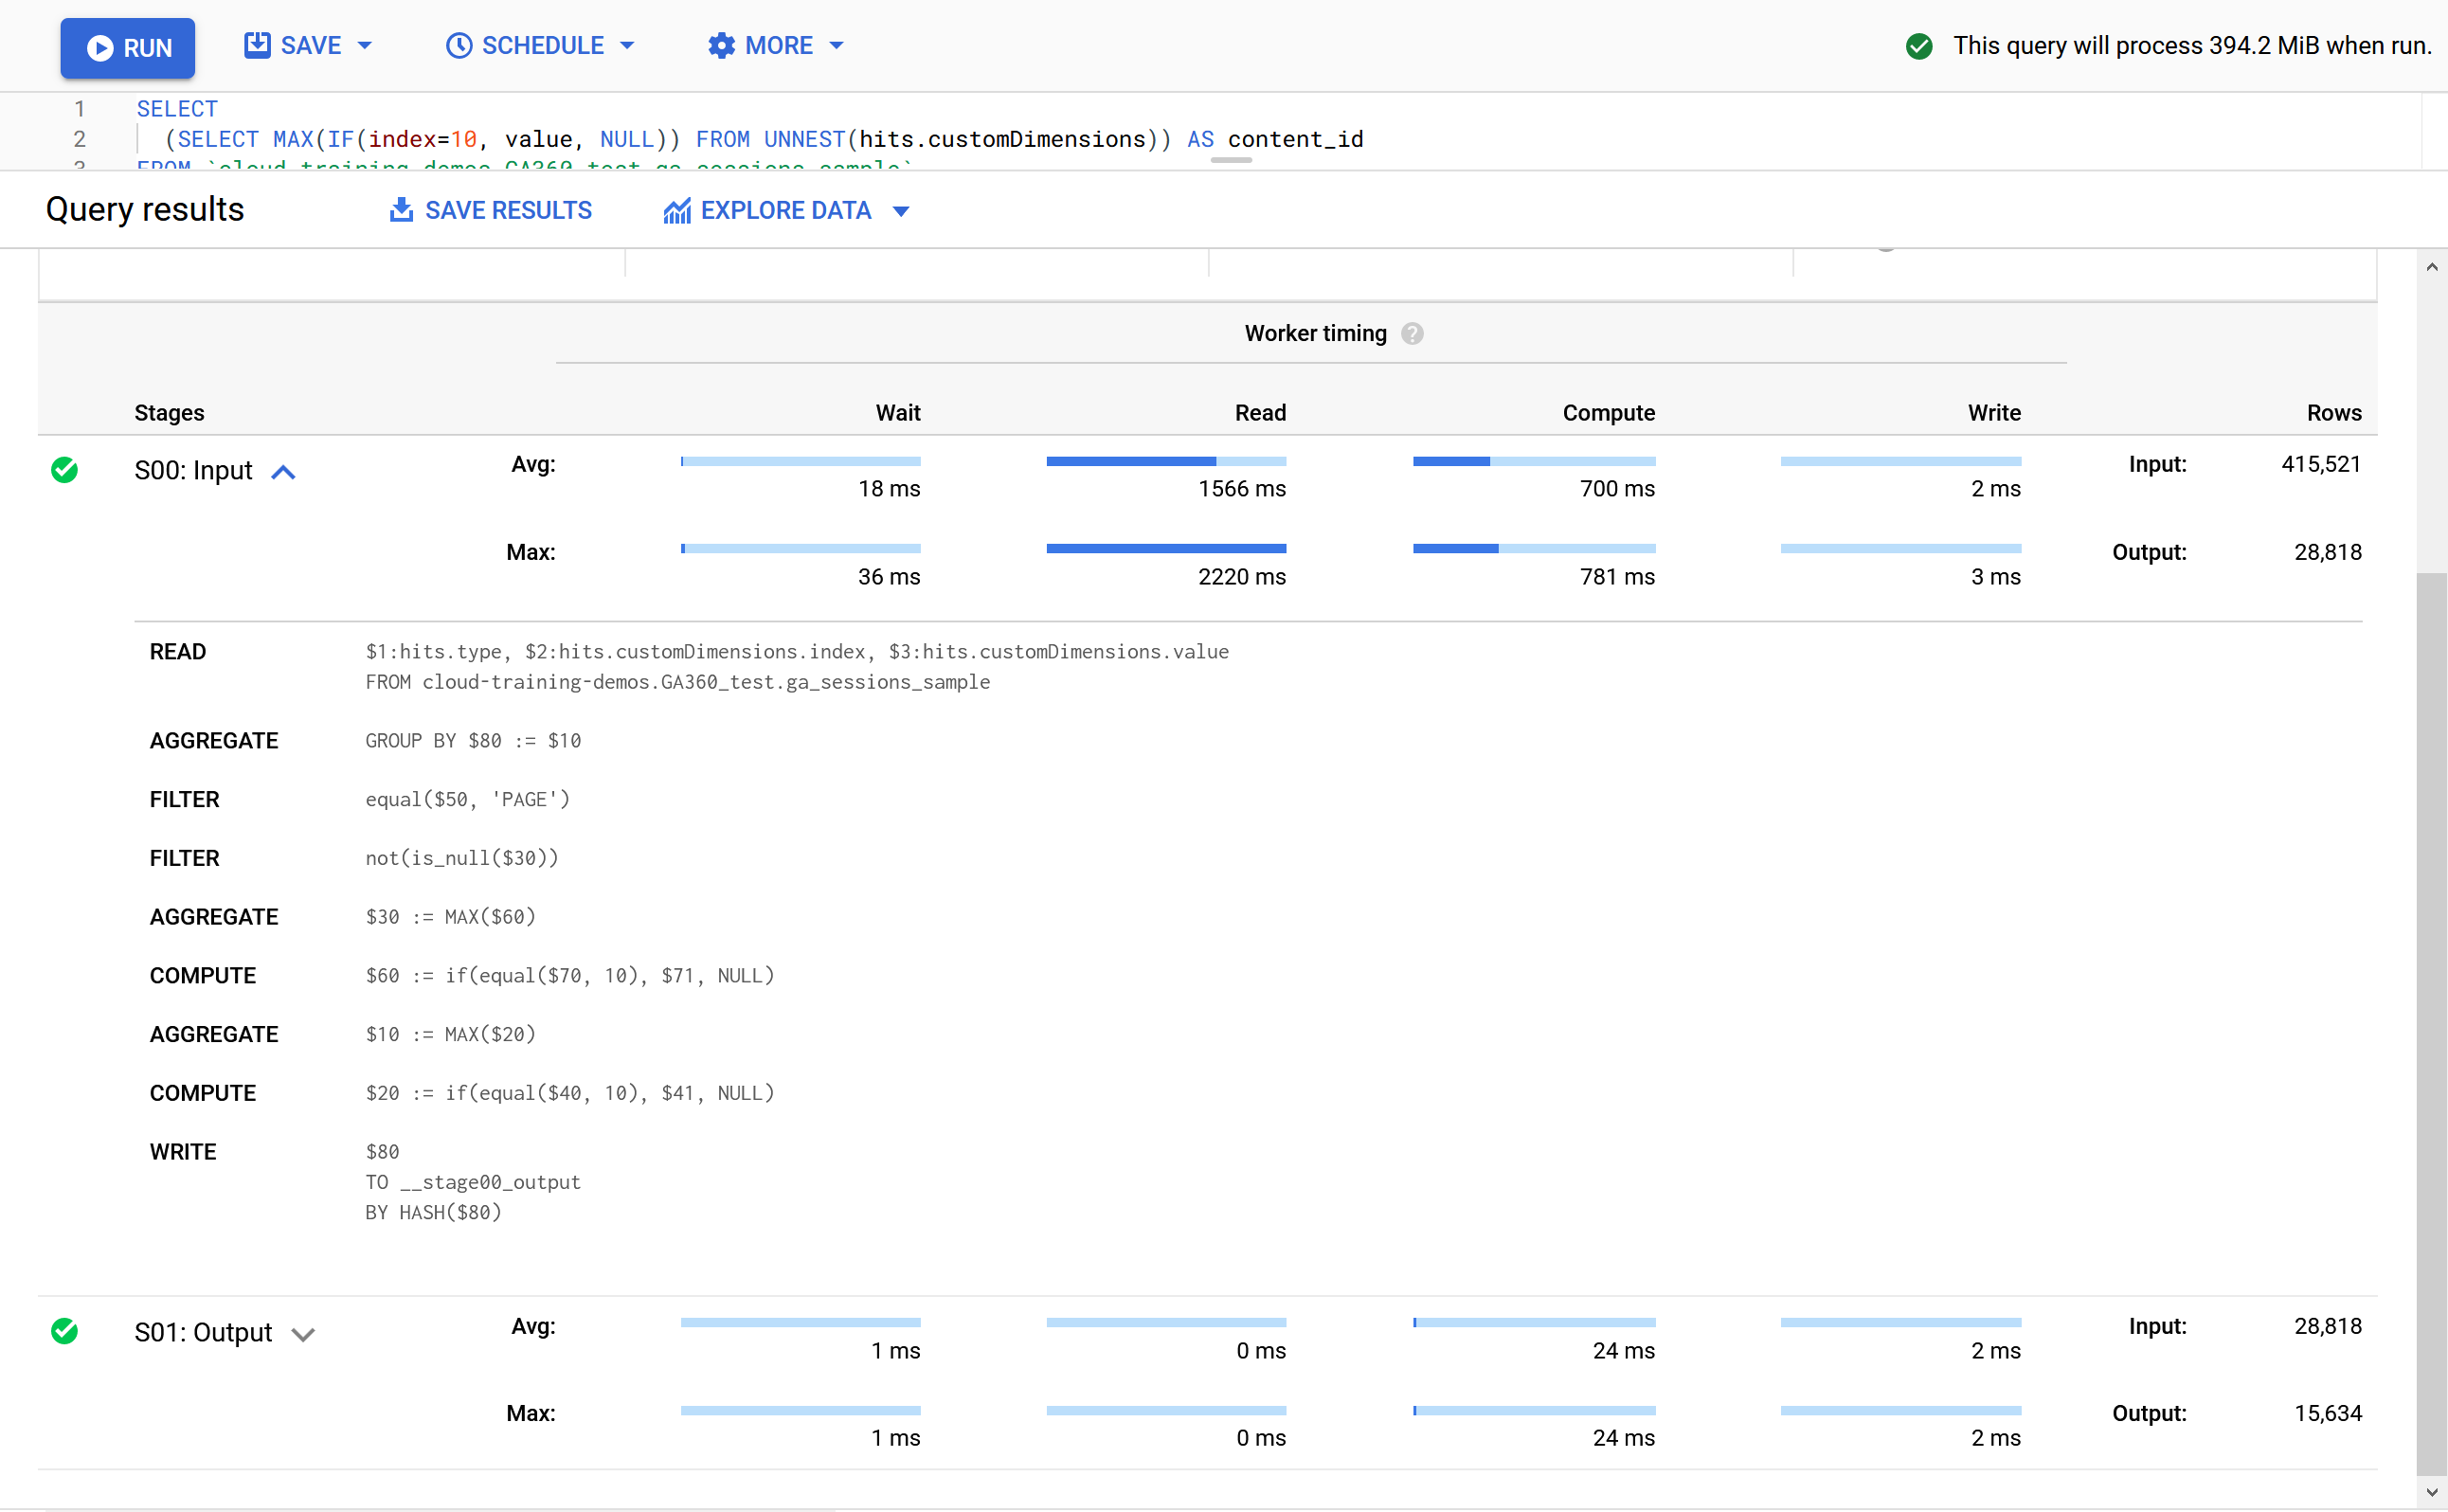

In [ ]:
query_contentID ="""
SELECT  
  (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS content_id 
FROM `cloud-training-demos.GA360_test.ga_sessions_sample`,   
  UNNEST(hits) AS hits
WHERE 
  hits.type = "PAGE"
  AND (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) IS NOT NULL
GROUP BY
  content_id  
"""

content_ids_list = client.query(query_contentID).to_dataframe()['content_id'].tolist()
print(content_ids_list[:5])

['299848776', '299823274', '299817990', '299820374', '299815643']


Similarly, I pull the list of article categories and authors.

In [ ]:
query_category="""
SELECT  
  (SELECT MAX(IF(index=7, value, NULL)) FROM UNNEST(hits.customDimensions)) AS category  
FROM `cloud-training-demos.GA360_test.ga_sessions_sample`,   
  UNNEST(hits) AS hits
WHERE 
  # only include hits on pages
  hits.type = "PAGE"
  AND (SELECT MAX(IF(index=7, value, NULL)) FROM UNNEST(hits.customDimensions)) IS NOT NULL
GROUP BY   
  category
"""

category_list = client.query(query_category).to_dataframe()['category'].tolist()
print(category_list)

['News', 'Lifestyle', 'Stars & Kultur']


In [ ]:
query_author="""
SELECT
  REGEXP_EXTRACT((SELECT MAX(IF(index=2, value, NULL)) FROM UNNEST(hits.customDimensions)), r"^[^,]+")  AS first_author  
FROM `cloud-training-demos.GA360_test.ga_sessions_sample`,   
  UNNEST(hits) AS hits
WHERE 
  # only include hits on pages
  hits.type = "PAGE"
  AND (SELECT MAX(IF(index=2, value, NULL)) FROM UNNEST(hits.customDimensions)) IS NOT NULL
GROUP BY   
  first_author
"""

author_list = client.query(query_author).to_dataframe()['first_author'].tolist()
print(author_list[:5])

['Alexander Huber', 'Christine Klafl', 'Philipp Albrechtsberger', 'Wolfgang Atzenhofer', 'Marlene Patsalidis']


# 2. Create train and test sets.

In this section, we create the train (90%) and test (10%) sets and store them into two cvs files. 

In [ ]:
query_train="""
WITH site_history as (
  SELECT
      fullVisitorId as visitor_id,
      (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS content_id,
      (SELECT MAX(IF(index=7, value, NULL)) FROM UNNEST(hits.customDimensions)) AS category, 
      (SELECT MAX(IF(index=6, value, NULL)) FROM UNNEST(hits.customDimensions)) AS title,
      (SELECT MAX(IF(index=2, value, NULL)) FROM UNNEST(hits.customDimensions)) AS author_list,
      SPLIT(RPAD((SELECT MAX(IF(index=4, value, NULL)) FROM UNNEST(hits.customDimensions)), 7), '.') as year_month_array,
      LEAD(hits.customDimensions, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) as nextCustomDimensions
  FROM 
    `cloud-training-demos.GA360_test.ga_sessions_sample`,   
     UNNEST(hits) AS hits
   WHERE 
     # only include hits on pages
      hits.type = "PAGE"
      AND
      fullVisitorId IS NOT NULL
      AND
      hits.time != 0
      AND
      hits.time IS NOT NULL
      AND
      (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) IS NOT NULL
)
SELECT
  visitor_id,
  content_id,
  category,
  REGEXP_REPLACE(title, r",", "") as title,
  REGEXP_EXTRACT(author_list, r"^[^,]+") as author,
  DATE_DIFF(DATE(CAST(year_month_array[OFFSET(0)] AS INT64), CAST(year_month_array[OFFSET(1)] AS INT64), 1), DATE(1970,1,1), MONTH) as months_since_epoch,
  (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(nextCustomDimensions)) as next_content_id
FROM
  site_history
WHERE (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(nextCustomDimensions)) IS NOT NULL
      AND ABS(MOD(FARM_FINGERPRINT(CONCAT(visitor_id, content_id)), 10)) < 9
"""
training_set_df = client.query(query_train).to_dataframe()
training_set_df.to_csv('training_set.csv', header=False, index=False, encoding='utf-8')
training_set_df.head()

,visitor_id,content_id,category,title,author,months_since_epoch,next_content_id
0,1002711106576646390,298972803,News,"""Moslem-Mama"": FPÖ-Mann hat selbst iranische W...",Matthias Hofer,574,299925700
1,1006445481851268005,299799049,News,Höchste Vulkan-Warnstufe: Rund 550 österreichi...,Daniela Wahl,574,299772450
2,1052612446078436916,299823332,News,Öfter dicke Luft in Graz als die EU erlaubt,Elisabeth Holzer,574,299965853
3,1052612446078436916,299975649,News,Großbritannien als Vorreiter: Viagra künftig r...,Stefan Berndl,574,299959624
4,1052612446078436916,299959624,News,OMV-Chef wünscht sich mehr Hilfe der Politik f...,Irmgard Kischko,574,299963428


In [ ]:
query_test ="""
WITH site_history as (
  SELECT
      fullVisitorId as visitor_id,
      (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS content_id,
      (SELECT MAX(IF(index=7, value, NULL)) FROM UNNEST(hits.customDimensions)) AS category, 
      (SELECT MAX(IF(index=6, value, NULL)) FROM UNNEST(hits.customDimensions)) AS title,
      (SELECT MAX(IF(index=2, value, NULL)) FROM UNNEST(hits.customDimensions)) AS author_list,
      SPLIT(RPAD((SELECT MAX(IF(index=4, value, NULL)) FROM UNNEST(hits.customDimensions)), 7), '.') as year_month_array,
      LEAD(hits.customDimensions, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) as nextCustomDimensions
  FROM 
    `cloud-training-demos.GA360_test.ga_sessions_sample`,   
     UNNEST(hits) AS hits
   WHERE 
     # only include hits on pages
      hits.type = "PAGE"
      AND
      fullVisitorId IS NOT NULL
      AND
      hits.time != 0
      AND
      hits.time IS NOT NULL
      AND
      (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) IS NOT NULL
)
SELECT
  visitor_id,
  content_id,
  category,
  REGEXP_REPLACE(title, r",", "") as title,
  REGEXP_EXTRACT(author_list, r"^[^,]+") as author,
  DATE_DIFF(DATE(CAST(year_month_array[OFFSET(0)] AS INT64), CAST(year_month_array[OFFSET(1)] AS INT64), 1), DATE(1970,1,1), MONTH) as months_since_epoch,
  (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(nextCustomDimensions)) as next_content_id
FROM
  site_history
WHERE (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(nextCustomDimensions)) IS NOT NULL
      AND ABS(MOD(FARM_FINGERPRINT(CONCAT(visitor_id, content_id)), 10)) >= 9
"""

test_set_df = client.query(query_test).to_dataframe()
test_set_df.to_csv('test_set.csv', header=False, index=False, encoding='utf-8')
test_set_df.head()

,visitor_id,content_id,category,title,author,months_since_epoch,next_content_id
0,1193761740249542720,299809756,Lifestyle,Youth Start European Entrepreneurship Award: S...,None,574,299935287
1,1278055348196598586,299567817,Lifestyle,Was Start-ups zu veganen Produkten verwursten,Hedwig Derka,574,299772450
2,1278055348196598586,299434007,Stars & Kultur,Katie Price: So knallhart vermarktet sie ihre ...,None,574,299804373
3,1583267569785034928,299828023,News,Glyphosat geht in die Verlängerung,Andreas Anzenberger,574,299816215
4,1901829331402723024,299824047,News,Mutmaßlicher Sechsfachmörder Aslan G.: Nun mus...,None,574,285840500
